In [1]:
import numpy as np

In [2]:
from pathlib import Path
from glob import glob

images_test = list(Path('CamVid/test').glob('*.png'))
images_test = sorted(images_test)

masks_test = list(Path('CamVid/test_labels').glob('*.png'))
masks_test = sorted(masks_test)

images_train = list(Path('CamVid/train').glob('*.png'))
images_train = sorted(images_train)

masks_train = list(Path('CamVid/train_labels').glob('*.png'))
masks_train = sorted(masks_train)

images_val = list(Path('CamVid/val').glob('*.png'))
images_val = sorted(images_val)

masks_val = list(Path('CamVid/val_labels').glob('*.png'))
masks_val = sorted(masks_val)

assert len(images_test) == len(masks_test), 'Ошибка в количестве'
assert len(images_train) == len(masks_train), 'Ошибка в количестве'
assert len(images_val) == len(masks_val), 'Ошибка в количестве'

In [3]:
pairs_test = []
for path in images_test:
    pairs_test.append((path, Path('CamVid/test_labels') / (path.stem + '_L.png')))
    
pairs_train = []
for path in images_train:
    pairs_train.append((path, Path('CamVid/train_labels') / (path.stem + '_L.png')))
    
pairs_val = []
for path in images_val:
    pairs_val.append((path, Path('CamVid/val_labels') / (path.stem + '_L.png')))

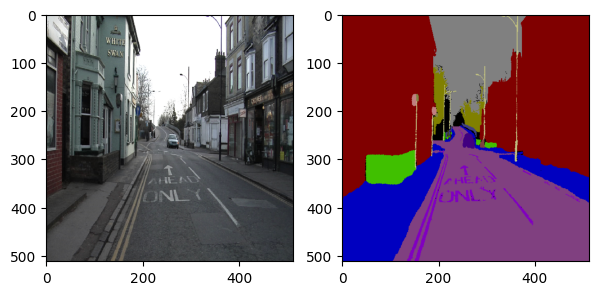

In [4]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as p
from random import choice

image_size = 512

image_mask = choice(pairs_val)
image = img_to_array(load_img(image_mask[0], target_size=(image_size, image_size)))
mask = img_to_array(load_img(image_mask[1], target_size=(image_size, image_size)))

p.figure(figsize=(7, 7))
p.subplot(1, 2, 1)
p.imshow(image/255)
p.subplot(1, 2, 2)
p.imshow(mask/255)

In [5]:
import pandas as pd

classes_table = pd.read_csv('CamVid/class_dict.csv')
classes_table

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [6]:
classes_rgb = []
for (ind, columns) in (classes_table.iterrows()):
    classes_rgb.append(np.array([columns['r'], columns['g'], columns['b']]))

In [7]:
def mask_to_nums(mask):
    mask = mask.astype('uint8')
    nums = np.zeros(mask.shape[:2], dtype= np.uint8)
    ind = 0
    for rgb in classes_rgb:
        nums[(mask == rgb).all(axis=2)] = ind
        ind = ind + 1
    return nums

In [8]:
from tensorflow.keras.utils import Sequence, to_categorical

class DataGenerator(Sequence):
    
    def __init__(self, pair, class_map, batch_size=16, dim=(512,512,3), shuffle=True):
        self.pair = pair
        self.class_map = class_map
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.pair) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [k for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

    def __data_generation(self, list_IDs_temp):
        batch_imgs = list()
        batch_masks = list()

        for i in list_IDs_temp:
            img = load_img(self.pair[i][0], target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)

            mask = load_img(self.pair[i][1], target_size=self.dim)
            mask = img_to_array(mask)
            mask = mask_to_nums(mask)
            mask = to_categorical(mask, num_classes = 32)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.pair))
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [36]:
train_generator = DataGenerator(pairs_train, classes_rgb, batch_size=4, dim=(image_size, image_size, 3), shuffle=True)
val_generator = DataGenerator(pairs_val, classes_rgb, batch_size=4, dim=(image_size, image_size, 3), shuffle=True)
steps_train = train_generator.__len__()
steps_val = val_generator.__len__()

dX, y = train_generator.__getitem__(1)
y.shape

(4, 512, 512, 32)

In [37]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose
import segmentation_models as sm
from tensorflow.keras.optimizers import Adam

image_input = Input(shape=(image_size, image_size, 3))

conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(image_input)
conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv_1)
pool_1 = MaxPooling2D((2, 2))(conv_1)

conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool_1)
conv_2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv_2)
pool_2 = MaxPooling2D((2, 2))(conv_2)

conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool_2)
conv_3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv_3)
pool_3 = MaxPooling2D((2, 2))(conv_3)

conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_3)
conv_4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv_4)
pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)


conv_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_4)
conv_5 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_5)
pool_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)

conv_6 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_5)
conv_6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv_6)
pool_6 = MaxPooling2D(pool_size=(2, 2))(conv_6)

conv_7 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool_6)
conv_7 = Conv2D(1024, (3, 3), activation='relu', padding='same') (conv_7)

upSampling_1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv_7)
up_conv_1 = concatenate([upSampling_1, conv_6])
up_conv_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up_conv_1)
up_conv_1 = Conv2D(512, (3, 3), activation='relu', padding='same')(up_conv_1)

upSampling_2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(up_conv_1)
up_conv_2 = concatenate([upSampling_2, conv_5])
up_conv_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up_conv_2)
up_conv_2 = Conv2D(256, (3, 3), activation='relu', padding='same')(up_conv_2)


upSampling_3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(up_conv_2)
up_conv_3 = concatenate([upSampling_3, conv_4])
up_conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up_conv_3)
up_conv_3 = Conv2D(128, (3, 3), activation='relu', padding='same')(up_conv_3)

upSampling_4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up_conv_3)
up_conv_4 = concatenate([upSampling_4, conv_3])
up_conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up_conv_4)
up_conv_4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up_conv_4)

upSampling_5 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(up_conv_4)
up_conv_5 = concatenate([upSampling_5, conv_2])
up_conv_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up_conv_5)
up_conv_5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up_conv_5)

upSampling_6 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(up_conv_5)
up_conv_5 = concatenate([upSampling_6, conv_1], axis=3)
up_conv_5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up_conv_5)
up_conv_5 = Conv2D(16, (3, 3), activation='relu', padding='same')(up_conv_5)

result = Conv2D(32, (1, 1), activation='softmax')(up_conv_5)

iou = sm.metrics.IOUScore(threshold=0.5)
unet = Model(inputs=[image_input], outputs=[result])
unet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', iou])

result.shape

TensorShape([None, 512, 512, 32])

In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

chekpoints = ModelCheckpoint(mode='max', filepath='unet.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
earlystop = EarlyStopping(mode='max', monitor='val_accuracy', patience=10, verbose=1)

In [39]:
unet.load_weights('unet.h5')

In [ ]:
unet.fit(train_generator,
         steps_per_epoch=steps_train,
         epochs=200,
         validation_data=val_generator,
         validation_steps=steps_val,
         callbacks=[chekpoints, earlystop])

In [40]:
def prediction(image_path):
    image = img_to_array(load_img(image_path, target_size = (image_size, image_size, 3)))/255.
    image = np.expand_dims(image, axis=0)
    mask = unet.predict(image)
    mask = np.argmax(mask[0], axis=2)
    return mask

def colorize(predicted):
    classes_rgb_np = np.array(classes_rgb)
    color_mask = np.zeros((image_size, image_size, 3),dtype=np.uint8)    
    color_mask = classes_rgb_np[predicted]
    color_mask = color_mask.astype(np.uint8)
    return color_mask

1/1 [==============================] - 0s 423ms/step


Text(0.5, 1.0, 'Результат')

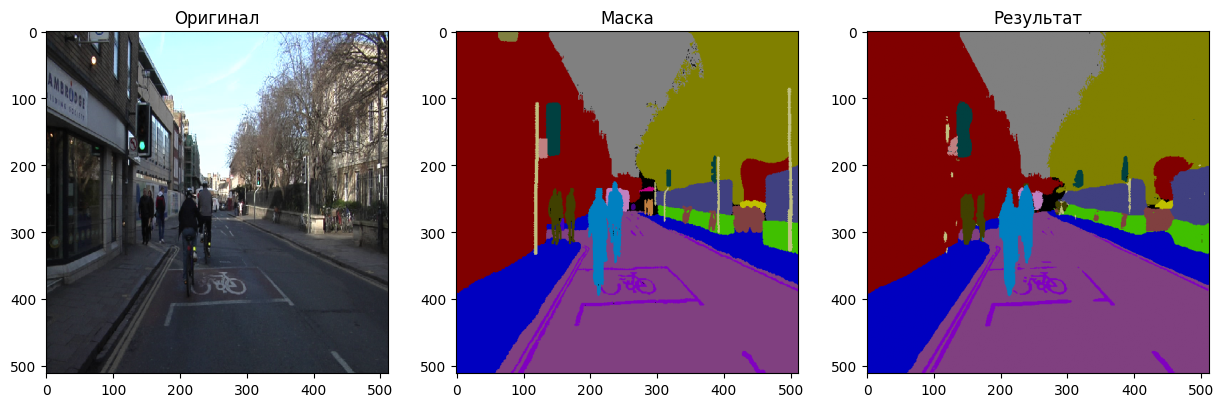

In [44]:
pair_to_show = choice(pairs_test)
test_image = img_to_array(load_img(pair_to_show[0], target_size=(image_size, image_size)))
test_mask = img_to_array(load_img(pair_to_show[1], target_size=(image_size, image_size)))

predicted_mask = prediction(pair_to_show[0])
predicted_mask.shape
predicted_mask = colorize(predicted_mask)

p.figure(figsize=(15,15))
p.subplot(1, 3, 1);p.title('Оригинал')
p.imshow(test_image/255)
p.subplot(1, 3, 2);p.title('Маска')
p.imshow(test_mask/255)
p.subplot(1, 3, 3)
p.imshow(predicted_mask/255);p.title('Результат')

1/1 [==============================] - 0s 418ms/step


Text(0.5, 1.0, 'Результат')

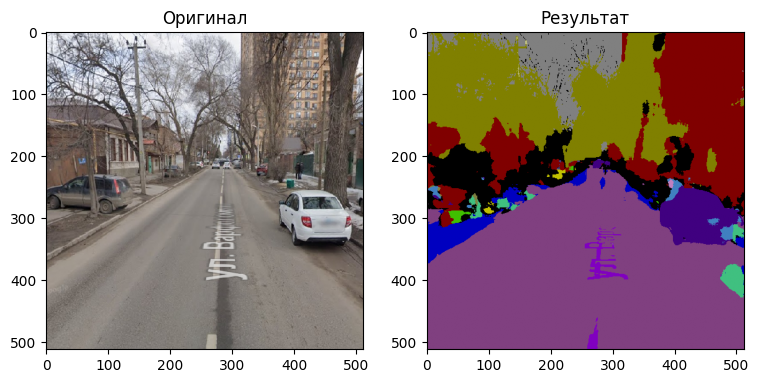

In [45]:
path = Path('Rostov_streets/Rostov1.jpg')

test_image = img_to_array(load_img(path, target_size=(image_size, image_size)))

predicted_mask = prediction(path)
predicted_mask.shape
predicted_mask = colorize(predicted_mask)

p.figure(figsize=(9, 9))
p.subplot(1, 2, 1);p.title('Оригинал')
p.imshow(test_image/255)
p.subplot(1, 2, 2)
p.imshow(predicted_mask/255);p.title('Результат')